In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import math

#we're going to use a RNN to map a sequence to a latent vector representation
input_dim = 100
sequence_length = 10
latent_dim = 10

#def get_sequence_class0():
    #nonsense sequence
#    return (torch.rand(sequence_length, input_dim) * 2) - 1

def get_sequence_class0():
    #let's make a square wave similar to class 1, but square obviously
    offset = torch.rand(1)[0] * 6.28
    #y = torch.rand(sequence_length, input_dim) - 0.5
    y = torch.zeros(sequence_length, input_dim)
    for i in range(0, sequence_length):
        y[i] += round(math.sin(i + offset)) #* 0.5
    
    return y
    
    
in_sequence = get_sequence_class0()
print(in_sequence)

def get_sequence_class1():
    #make this class notably non-linear
    #and add a noisy but discernable sequence to it
    offset = torch.rand(1)[0] * 6.28
    #y = torch.rand(sequence_length, input_dim) - 0.5
    y = torch.zeros(sequence_length, input_dim)
    for i in range(0, sequence_length):
        y[i] += math.sin(i + offset) #* 0.5
    
    return y
    

#shift one so it's sequence is from a notably different distribution
shifted_in_sequence = get_sequence_class1()
print(shifted_in_sequence)

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.

In [2]:
#This RNN maps an input sequence of any length to a latent vector of size "hidden size"
class LatentSpaceMappingRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LatentSpaceMappingRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.hidden_state = torch.zeros(self.hidden_size) 
        self.mapping = nn.Linear(input_size + hidden_size, hidden_size)
    
    def forward(self, x):
        self.init_hidden_state()
        y = torch.zeros(self.hidden_size)
        for s in range(0, x.shape[0]):
            y = torch.cat((x[s], self.hidden_state), 0)
            self.hidden_state = torch.tanh(self.mapping(y))
            
        return self.hidden_state
        
    def init_hidden_state(self):
        self.hidden_state = torch.zeros(self.hidden_size)
        return self.hidden_state
    
class GRUMapping(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRUMapping, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.hidden_state = torch.zeros(self.hidden_size) 
        self.mapping = nn.GRU(input_size, hidden_size)
    
    def forward(self, x):
        self.init_hidden_state()
        q = torch.zeros(x.shape[0], 1, x.shape[1])
        q[:, 0, :] = x[:, :]
        x, self.hidden_state = self.mapping(q, self.hidden_state)
        return self.hidden_state[0][0]
        
    def init_hidden_state(self):
        self.hidden_state = torch.zeros(1, 1, self.hidden_size)
        return self.hidden_state
    

#example
#lsm = LatentSpaceMappingRNN(input_dim, latent_dim)
lsm = GRUMapping(input_dim, latent_dim)
out = lsm(in_sequence).detach()
print(out)
out_shifted = lsm(shifted_in_sequence).detach()
print(out_shifted)
#for i in range(5):
#    print(lsm(get_sequence_class1()).detach())

tensor([ 3.1307e-01, -1.9795e-01,  5.4583e-01,  5.0122e-01, -1.6305e-01,
        -6.3837e-04, -4.1221e-01,  4.5436e-01, -4.1926e-01,  7.5621e-01])
tensor([ 0.1985, -0.0641,  0.4552,  0.4504, -0.1701, -0.0093, -0.5835,  0.4125,
        -0.3842,  0.6178])


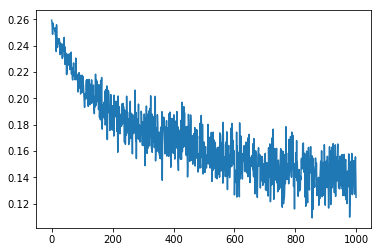

Correct:  8698
Accuracy:  0.8698


In [3]:
import matplotlib.pyplot as plt

#Now we make the logistic regression binary classifier
class LogisticRegressionBinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionBinaryClassifier, self).__init__()
        self.input_size = input_size
        self.mapping = nn.Linear(input_size, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.mapping(x))

#it will take our latent vector representations and classify them
#we want to see if the latent representation can meaningfully classify the original sequence
clf = LogisticRegressionBinaryClassifier(latent_dim)
criterion = nn.MSELoss()
optimizer = optim.SGD(clf.parameters(), lr=0.1)
loss_log = []

num_training_examples = 100000
for i in range(0,num_training_examples):
        
        #train on a sequence from the first class
        clf.zero_grad()
        #lsm.init_hidden_state()
        prediction = clf(lsm(get_sequence_class0()).detach())
        loss = criterion(prediction, torch.zeros(1))
        loss_log.append(loss.item())
        loss.backward()
        optimizer.step()
        
        #train on a sequence from the second class
        clf.zero_grad()
        #lsm.init_hidden_state()
        prediction = clf(lsm(get_sequence_class1()).detach())
        loss = criterion(prediction, torch.ones(1))
        loss_log.append(loss.item())
        loss.backward()
        optimizer.step()
        
#plot loss
loss_avg = []
for i in range(0, num_training_examples // 100):
    total = 0
    for k in loss_log[int(i * 100): int((i+1)*100)]:
        total += k
    loss_avg.append(total / 100)
    
plt.plot(range(len(loss_avg)), loss_avg)
plt.show()
        
#calculate the accuracy!
num_test_examples = 10000
num_correct = 0
for i in range(0, num_test_examples // 2):
    y = clf(lsm(get_sequence_class0()).detach())
    if y[0] < 0.5:
        num_correct += 1
        
    y = clf(lsm(get_sequence_class1()).detach())
    if y[0] >= 0.5:
        num_correct += 1
        
print("Correct: ", num_correct)
print("Accuracy: ", (num_correct / num_test_examples))

Using our real data set!
---------------------------------

So we've shown that a GRU is particularly good at mapping unique sequences into linearly separable representations. Let's try it with our real data (UNSW NB15) and see how well it can separate "attack" sequences from normal traffic.  

In [4]:
import feature_extraction
import unsw_nb15_dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from importlib import reload #allow us to reload custom modules any time we like with modifications
reload(feature_extraction)
reload(unsw_nb15_dataset)

<module 'unsw_nb15_dataset' from '/home/jaywalker/MachineLearning/PacketGAN/unsw_nb15_dataset.py'>

In [5]:
#First we need to load our "normal" and "attack" data in to random splits of equal size
normal_data = unsw_nb15_dataset.UNSW_NB15('/home/jaywalker/MachineLearning/PacketGAN/UNSW_NB15_full_clean.csv',
                                       sequence_length=sequence_length, 
                                       transform=feature_extraction.build_feature_sequence_tensor)
normal_data.use_only_label(0) #attack sequences are labeled 1

attack_data = unsw_nb15_dataset.UNSW_NB15('/home/jaywalker/MachineLearning/PacketGAN/UNSW_NB15_full_clean.csv',
                                       sequence_length=sequence_length, 
                                       transform=feature_extraction.build_feature_sequence_tensor)
attack_data.use_only_category('Exploits')

attack_test_length = round(len(attack_data) * 0.2)
attack_train_set, attack_test_set = random_split(attack_data, [len(attack_data) - attack_test_length, attack_test_length])
print("Length of attack training set: ", len(attack_train_set))
print("Length of attack test set: ", len(attack_test_set))

normal_test_length = attack_test_length
normal_train_length = len(attack_train_set)
normal_excluded_length = len(normal_data) - normal_train_length - normal_test_length
normal_train_set, normal_test_set, normal_excluded_set = random_split(normal_data, [normal_train_length, normal_test_length, normal_excluded_length])
print("Length of normal training set: ", len(normal_train_set))
print("Length of normal test set: ", len(normal_test_set))

/home/jaywalker/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Length of attack training set:  35612
Length of attack test set:  8903
Length of normal training set:  35612
Length of normal test set:  8903


In [6]:
print("Shape of a data element: ", normal_train_set[0].shape)
latent_dim = 25
lsm = GRUMapping(normal_train_set[0].shape[1], latent_dim)
out = lsm(normal_train_set[0]).detach()
print(out)

Shape of a data element:  torch.Size([10, 275])
tensor([-0.2940,  0.4355, -0.1384, -0.8709, -0.1328,  0.2577,  0.5526, -0.4301,
         0.3875,  0.4108, -0.2855,  0.1434, -0.6240, -0.0793,  0.4378, -0.7318,
        -0.0202,  0.2990, -0.3783,  0.7446,  0.6706,  0.0124, -0.3614, -0.8379,
        -0.1764])


In [7]:
class NeuralClassifier(nn.Module):
    def __init__(self, input_size, n_classes):
        super(NeuralClassifier, self).__init__()
        self.input_size = input_size
        self.mapping1 = nn.Linear(input_size, input_size)
        self.mapping2 = nn.Linear(input_size, n_classes)
        self.f = torch.sigmoid
    
    def forward(self, x):
        x = self.f(self.mapping1(x))
        return self.f(self.mapping2(x))

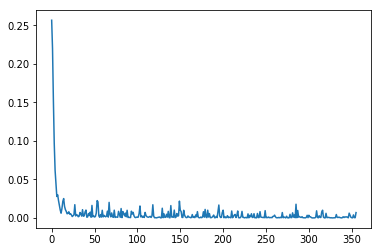

Correct:  17779
Accuracy:  0.9984836571942042


In [8]:
#it will take our latent vector representations and classify them
#we want to see if the latent representation can meaningfully classify the original sequence
#clf = LogisticRegressionBinaryClassifier(latent_dim)
clf = NeuralClassifier(latent_dim, 1)
criterion = nn.MSELoss()
optimizer = optim.SGD(clf.parameters(), lr=0.1)
loss_log = []

#TODO add the neural classifier to this set and see how it compares

for i in range(0, normal_train_length):
        
        #train on a sequence from the normal data
        clf.zero_grad()
        prediction = clf(lsm(normal_train_set[i]).detach())
        loss = criterion(prediction, torch.zeros(1))
        loss_log.append(loss.item())
        loss.backward()
        optimizer.step()
        
        #train on a sequence from the attack
        clf.zero_grad()
        prediction = clf(lsm(attack_train_set[i]).detach())
        loss = criterion(prediction, torch.ones(1))
        loss_log.append(loss.item())
        loss.backward()
        optimizer.step()
        
#plot loss
loss_avg = []
for i in range(0, normal_train_length // 100):
    total = 0
    for k in loss_log[int(i * 100): int((i+1)*100)]:
        total += k
    loss_avg.append(total / 100)
    
plt.plot(range(len(loss_avg)), loss_avg)
plt.show()
        
#calculate the accuracy!
num_test_examples = len(normal_test_set) + len(attack_test_set)
num_correct = 0
for i in range(0, len(normal_test_set)):
    y = clf(lsm(normal_test_set[i]).detach())
    if y[0] < 0.5:
        num_correct += 1
        
    y = clf(lsm(attack_test_set[i]).detach())
    if y[0] >= 0.5:
        num_correct += 1
        
print("Correct: ", num_correct)
print("Accuracy: ", (num_correct / num_test_examples))